In [4]:
import sys
sys.path.append("..")

import numpy as np
import glob
import matplotlib.pyplot as plt
import pandas as pd
#from spiralcutter_advanced.libs.spiral_funcs import *
#from spiralcutter_advanced.libs.profile_funcs import *
#from spiralcutter_advanced.libs.helper_funcs import *
from scipy.optimize import curve_fit
from astropy.io import fits

In [5]:
def model_base(params, phi, r, rho):
    I0, ih, ih2, ih3, gr, co, st, endcor, w0, w1, w2, S0, S1, ncor = params
    end = 1 - endcor
    ninv = 1 / (ncor + 0.5)

    g_gr = np.exp(-((phi - st - gr) ** 2) / (2 * (gr / 3) ** 2))
    g_e = np.exp(-((phi - end + co) ** 2) / (2 * (co / 3) ** 2))
    hvs = np.where(phi < st + gr, g_gr, 1)
    hvs = hvs * np.where(phi > end - co, g_e, 1)
    I_parallel = I0 * np.exp(-(ih * r + ih2 * r ** 2 + ih3 * r ** 3)) * hvs

    w_loc = w0 + w1 * r + w2 * r ** 2
    S_loc = S0 + S1 * r
    #offset = rho + o0 + (o1 * r)
    offset = rho
    w_in = w_loc * (1 - S_loc) / 2
    w_out = w_loc * (1 + S_loc) / 2
    offset = rho + (w_out - w_in) / 2

    I_perp_in = np.exp(-np.log(2) * np.power(np.abs(offset / w_in), ninv))
    I_perp_out = np.exp(-np.log(2) * np.power(np.abs(offset / w_out), ninv))
    I_perp = np.where(offset > 0, I_perp_out, I_perp_in)

    I = I_parallel * I_perp
    return I

d_cat = {
        "NGC0628_blue": [1.5],
        "NGC1042_green": [4],
        "NGC1042_red": [3.5],
        "NGC1073_green": [1.75],
        "NGC1232_green": [2.5, 5],
        "NGC1232_red": [5.5],
        "NGC1300_green": [2.25, 5.25],
        "NGC1300_red": [2.5],
        "NGC1566_green": [6],
        "NGC1566_red": [6],
        "NGC4123_cyan": [2],
        "NGC4535_green": [2],
        "NGC4535_red": [2],
        "NGC4321_red": [2.5, 5],
        "NGC5247_blue": [3, 6]
    }

good_arms = {
        "NGC0613": ["cyan", "green", "magenta"],
        "NGC0628": ["red"],#["green", "red"],
        "NGC0986": ["green", "red"],
        "NGC1042": [],#["green", "red"],
        "NGC1073": [],#["green", "red"],
        "NGC1232": ["cyan", "red"],#["cyan", "green", "red"],
        "NGC1300": ["green", "red"],
        "NGC1566": [],
        "NGC1672": ["green", "red"], #high chisq
        "NGC3184": ["blue", "green", "red"],
        "NGC4123": [],#["green", "red"],
        "NGC4254": ["green", "red"], #high chisq
        "NGC4303": ["green"],#["green", "red"], #high chisq
        "NGC4321": ["cyan", "green", "red"],
        "NGC4535": ["green", "red"],
        "NGC5085": [],#"red"],
        "NGC5236": ["blue", "green", "red"], #very high chisq
        "NGC5247": ["cyan", "green", "red"],
        "NGC7412": ["cyan", "green", "red"]
}

i = 0
no_dip_inds = []

for gal in good_arms:
    arms = good_arms[gal]
    for arm in arms:
        arm_string = f"{gal}_{arm}"
        if not arm_string in d_cat:
            no_dip_inds.append(i)
        i = i + 1

no_dip_inds = np.array(no_dip_inds)
print(no_dip_inds)

[ 0  1  2  3  4  5  6 10 11 12 13 14 15 16 17 18 19 23 24 25 26 27 28 29
 30 31]


/tmp/ipykernel_660/1131324875.py:85: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


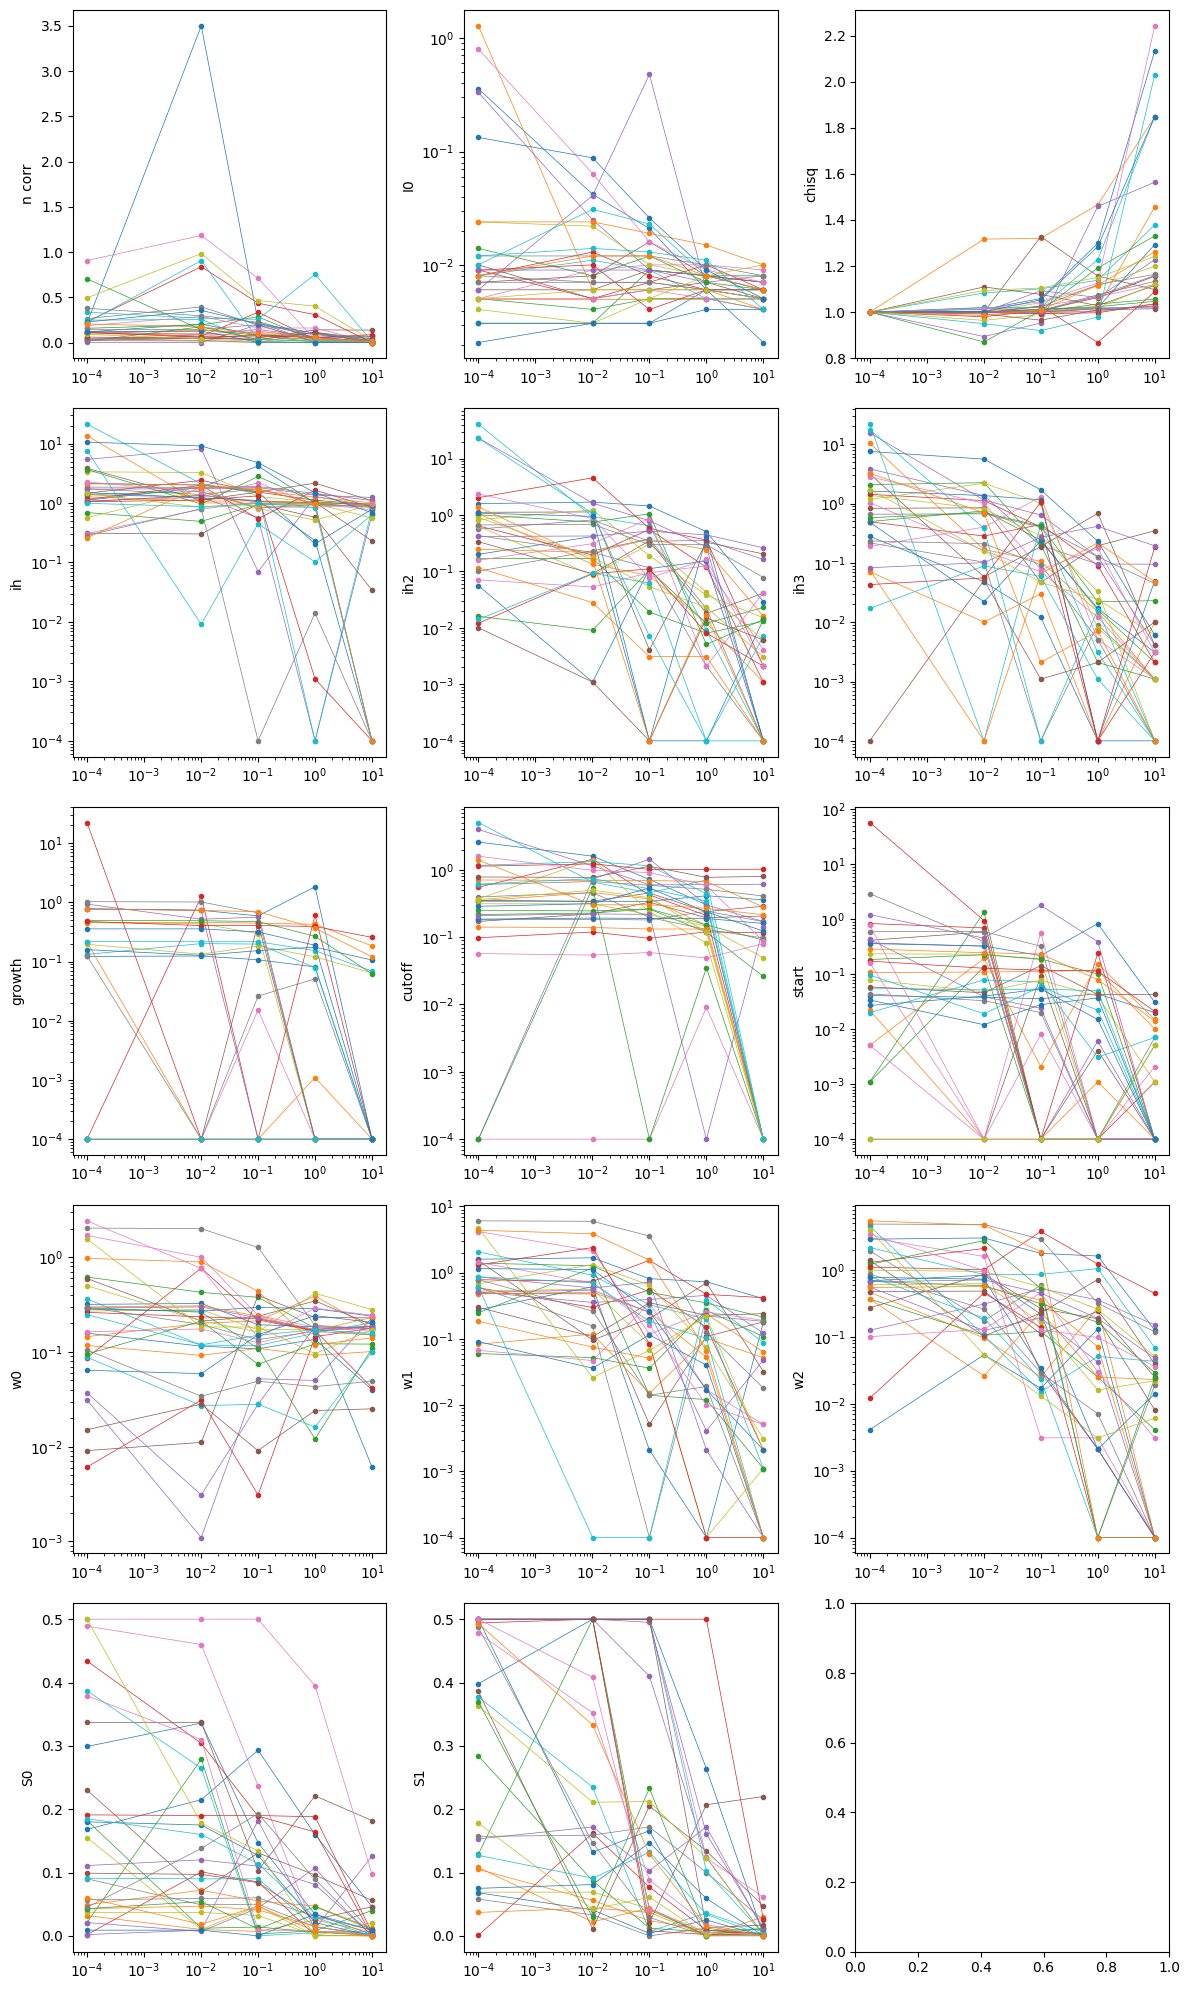

In [20]:
fig, axs = plt.subplots(figsize=[12,20], ncols = 3, nrows = 5)

all_tables = []

for gal in good_arms:
    arms = good_arms[gal]
    for arm in arms:
        path = f"../tables/{gal}_{arm}.dat"
        path_l = f"../galaxies_images/{gal}/str_arms_azavg/arm_str_{arm}.fits"
        arm_img = fits.getdata(path_l)[:, 60:-60]
        l_psi = np.shape(arm_img)[1] / 2
        #print(l_psi)
        #if l_psi > 180:
        #    continue
        a = np.genfromtxt(path)
        #if np.sum(a[:, -1] > 1) > 0:
        #    continue
        
        all_tables.append(a)
        
        axs[0, 0].plot(a[:, 0] + 1e-4, np.abs(a[:, 15]) + 1e-4, lw = 0.5, marker = "o", ms = 3)
        axs[0, 1].plot(a[:, 0] + 1e-4, np.abs(a[:, 2]) + 1e-4, lw = 0.5, marker = "o", ms = 3)
        
        axs[0, 2].plot(a[:, 0] + 1e-4, np.abs(a[:, 1] / a[0, 1]), lw = 0.5, marker = "o", ms = 3)
        
        axs[1, 0].plot(a[:, 0] + 1e-4, np.abs(a[:, 3]) + 1e-4, lw = 0.5, marker = "o", ms = 3)
        axs[1, 1].plot(a[:, 0] + 1e-4, np.abs(a[:, 4]) + 1e-4, lw = 0.5, marker = "o", ms = 3)
        axs[1, 2].plot(a[:, 0] + 1e-4, np.abs(a[:, 5]) + 1e-4, lw = 0.5, marker = "o", ms = 3)
        
        axs[2, 0].plot(a[:, 0] + 1e-4, np.abs(a[:, 6]) + 1e-4, lw = 0.5, marker = "o", ms = 3)
        axs[2, 1].plot(a[:, 0] + 1e-4, np.abs(a[:, 7]) + 1e-4, lw = 0.5, marker = "o", ms = 3)
        axs[2, 2].plot(a[:, 0] + 1e-4, np.abs(a[:, 8]) + 1e-4, lw = 0.5, marker = "o", ms = 3)
        
        axs[3, 0].plot(a[:, 0] + 1e-4, np.abs(a[:, 10]) + 1e-4, lw = 0.5, marker = "o", ms = 3)
        axs[3, 1].plot(a[:, 0] + 1e-4, np.abs(a[:, 11]) + 1e-4, lw = 0.5, marker = "o", ms = 3)
        axs[3, 2].plot(a[:, 0] + 1e-4, np.abs(a[:, 12]) + 1e-4, lw = 0.5, marker = "o", ms = 3)
        
        axs[4, 0].plot(a[:, 0] + 1e-4, np.abs(a[:, 13]) + 1e-4, lw = 0.5, marker = "o", ms = 3)
        axs[4, 1].plot(a[:, 0] + 1e-4, np.abs(a[:, 14]) + 1e-4, lw = 0.5, marker = "o", ms = 3)

axs[0, 0].set_xscale("log")
axs[0, 0].set_ylabel("n corr")
axs[0, 1].set_xscale("log")
axs[0, 1].set_yscale("log")
axs[0, 1].set_ylabel("I0")
axs[0, 2].set_xscale("log")
axs[0, 2].set_ylabel("chisq")

axs[1, 0].set_xscale("log")
axs[1, 0].set_yscale("log")
axs[1, 0].set_ylabel("ih")
axs[1, 1].set_xscale("log")
axs[1, 1].set_yscale("log")
axs[1, 1].set_ylabel("ih2")
axs[1, 2].set_xscale("log")
axs[1, 2].set_yscale("log")
axs[1, 2].set_ylabel("ih3")

axs[2, 0].set_xscale("log")
axs[2, 0].set_yscale("log")
axs[2, 0].set_ylabel("growth")
axs[2, 1].set_xscale("log")
axs[2, 1].set_yscale("log")
axs[2, 1].set_ylabel("cutoff")
axs[2, 2].set_xscale("log")
axs[2, 2].set_yscale("log")
axs[2, 2].set_ylabel("start")

axs[3, 0].set_xscale("log")
axs[3, 0].set_yscale("log")
axs[3, 0].set_ylabel("w0")
axs[3, 1].set_xscale("log")
axs[3, 1].set_yscale("log")
axs[3, 1].set_ylabel("w1")
axs[3, 2].set_xscale("log")
axs[3, 2].set_yscale("log")
axs[3, 2].set_ylabel("w2")

axs[4, 0].set_xscale("log")
axs[4, 0].set_ylabel("S0")
axs[4, 1].set_xscale("log")
axs[4, 1].set_ylabel("S1")

fig.tight_layout()
fig.show()

/tmp/ipykernel_660/1173625128.py:29: RuntimeWarning: invalid value encountered in divide
  zc_median = np.nansum(zero_median, axis = 0) / np.nansum(~zpar, axis = 0)
/tmp/ipykernel_660/1173625128.py:30: RuntimeWarning: invalid value encountered in divide
  zc_indiv = np.nansum(zero_indiv, axis = 0) / np.nansum(~zpar, axis = 0)
/tmp/ipykernel_660/1173625128.py:91: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


[[       nan 0.         0.         0.         0.15625    0.16129032
  0.         0.         0.13333333 0.09375    0.09375    0.03125
  0.0625     0.09375    0.0625     0.03125   ]
 [       nan 0.         0.         0.03125    0.15625    0.25806452
  0.16666667 0.         0.13333333 0.0625     0.09375    0.15625
  0.09375    0.15625    0.125      0.03125   ]
 [       nan 0.         0.         0.0625     0.28125    0.38709677
  0.22222222 0.         0.36666667 0.1875     0.0625     0.28125
  0.28125    0.15625    0.28125    0.15625   ]
 [       nan 0.         0.         0.15625    0.59375    0.70967742
  0.33333333 0.03448276 0.5        0.3125     0.09375    0.375
  0.5625     0.3125     0.625      0.1875    ]
 [       nan 0.         0.         0.21875    0.875      0.87096774
  0.61111111 0.34482759 0.8        0.4375     0.0625     0.65625
  0.875      0.71875    0.90625    0.65625   ]]
['lambda', 'chisq', 'I0', 'ih', 'ih2', 'ih3', 'growth', 'cutoff', 'start', 'endcorr', 'w0', 'w1', 'w2

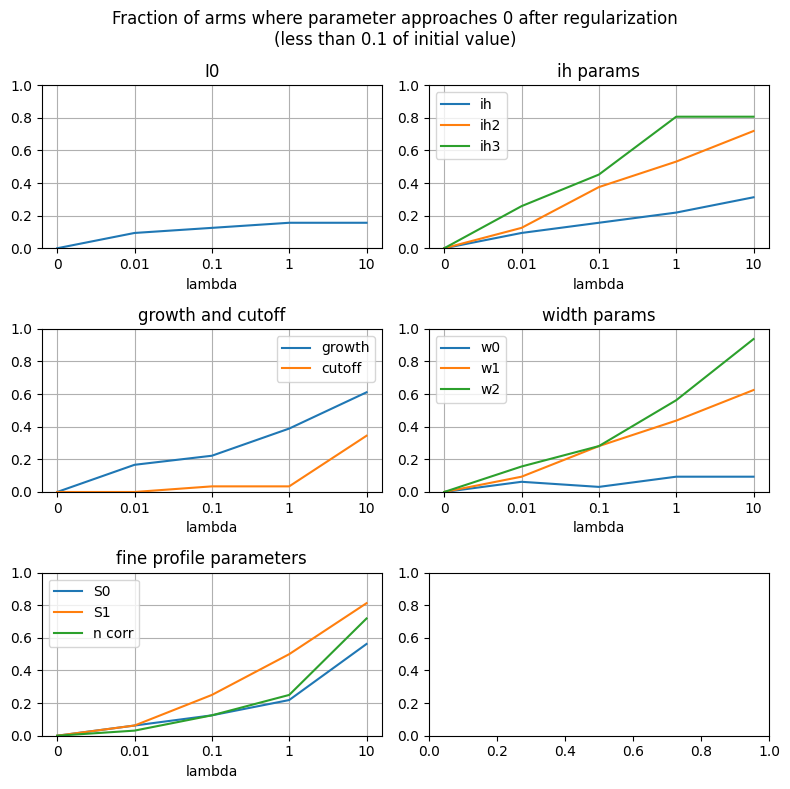

In [27]:
all_tables = np.array(all_tables)

pnames = ["lambda", "chisq", "I0", "ih", "ih2", "ih3", "growth", "cutoff", "start", "endcorr", "w0", "w1", "w2", "S0", "S1", "ncor"]

fig, axs = plt.subplots(figsize=[8,8], ncols = 2, nrows = 3)

#all_tables[:, 2, -1] #galaxy (:), lambda, parameter

#print(all_tables[:, 0, :])

zpar = all_tables[:, 0, :] == 0

medians = np.median(np.abs(all_tables[:, 0, :]), axis = 0)
#print(medians)

gcount = len(all_tables[:, 0, 0])
#print(gcount)
gcount = 1

#for lam_i in [0, 1, 2, 3, 4]:
zero_median = (np.abs(all_tables[:, :, :]) < medians / 10)
zero_indiv = np.zeros_like(zero_median)
for lam_i in [0, 1, 2, 3, 4]:
    zero_indiv[:, lam_i, :] = (np.abs(all_tables[:, lam_i, :]) < np.abs(all_tables[:, 0, :]) / 10)
    
    zero_median[:, lam_i, :] = zero_median[:, lam_i, :] * ~zpar
    zero_indiv[:, lam_i, :] = zero_indiv[:, lam_i, :] * ~zpar
    
zc_median = np.nansum(zero_median, axis = 0) / np.nansum(~zpar, axis = 0)
zc_indiv = np.nansum(zero_indiv, axis = 0) / np.nansum(~zpar, axis = 0)

axs[0, 0].plot(zc_indiv[:, 2] / gcount)
axs[0, 0].set_ylim(0, 1)
axs[0, 0].set_title("I0")
axs[0, 0].set_xticks([0, 1, 2, 3, 4])
axs[0, 0].set_xticklabels([0, 0.01, 0.1, 1, 10])
axs[0, 0].set_xlabel("lambda")
axs[0, 0].grid()

axs[0, 1].plot(zc_indiv[:, 3] / gcount, label = "ih")
axs[0, 1].plot(zc_indiv[:, 4] / gcount, label = "ih2")
axs[0, 1].plot(zc_indiv[:, 5] / gcount, label = "ih3")
axs[0, 1].set_ylim(0, 1)
axs[0, 1].set_title("ih params")
axs[0, 1].set_xticks([0, 1, 2, 3, 4])
axs[0, 1].set_xticklabels([0, 0.01, 0.1, 1, 10])
axs[0, 1].set_xlabel("lambda")
axs[0, 1].legend()
axs[0, 1].grid()

axs[1, 0].plot(zc_indiv[:, 6] / gcount, label = "growth")
axs[1, 0].plot(zc_indiv[:, 7] / gcount, label = "cutoff")
#axs[1, 0].plot(zc_indiv[:, 8] / gcount, label = "start")
axs[1, 0].set_ylim(0, 1)
axs[1, 0].set_title("growth and cutoff")
axs[1, 0].set_xticks([0, 1, 2, 3, 4])
axs[1, 0].set_xticklabels([0, 0.01, 0.1, 1, 10])
axs[1, 0].set_xlabel("lambda")
axs[1, 0].legend()
axs[1, 0].grid()

axs[1, 1].plot(zc_indiv[:, 10] / gcount, label = "w0")
axs[1, 1].plot(zc_indiv[:, 11] / gcount, label = "w1")
axs[1, 1].plot(zc_indiv[:, 12] / gcount, label = "w2")
axs[1, 1].set_ylim(0, 1)
axs[1, 1].set_title("width params")
axs[1, 1].set_xticks([0, 1, 2, 3, 4])
axs[1, 1].set_xticklabels([0, 0.01, 0.1, 1, 10])
axs[1, 1].set_xlabel("lambda")
axs[1, 1].legend()
axs[1, 1].grid()

axs[2, 0].plot(zc_indiv[:, 13] / gcount, label = "S0")
axs[2, 0].plot(zc_indiv[:, 14] / gcount, label = "S1")
axs[2, 0].plot(zc_indiv[:, 15] / gcount, label = "n corr")
axs[2, 0].set_ylim(0, 1)
axs[2, 0].set_title("fine profile parameters")
axs[2, 0].set_xticks([0, 1, 2, 3, 4])
axs[2, 0].set_xticklabels([0, 0.01, 0.1, 1, 10])
axs[2, 0].set_xlabel("lambda")
axs[2, 0].legend()
axs[2, 0].grid()

fig.suptitle("Fraction of arms where parameter approaches 0 after regularization\n(less than 0.1 of initial value)")
    
print(zc_median)
print(pnames)
print(zc_indiv)

fig.tight_layout()
fig.show()
    #print(a)

/tmp/ipykernel_660/3450360986.py:58: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


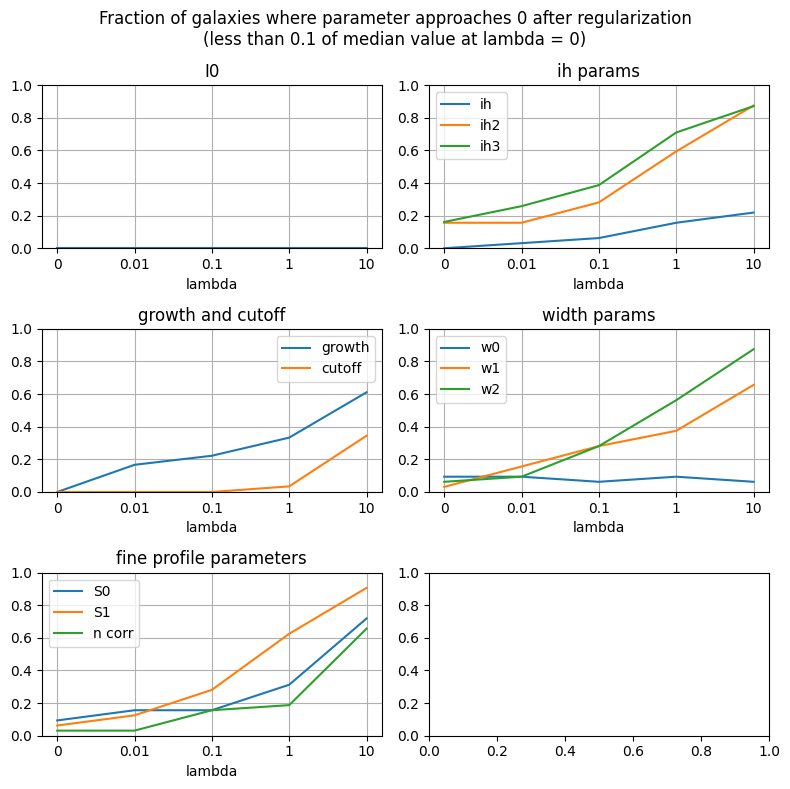

In [28]:
fig, axs = plt.subplots(figsize=[8,8], ncols = 2, nrows = 3)

axs[0, 0].plot(zc_median[:, 2] / gcount)
axs[0, 0].set_ylim(0, 1)
axs[0, 0].set_title("I0")
axs[0, 0].set_xticks([0, 1, 2, 3, 4])
axs[0, 0].set_xticklabels([0, 0.01, 0.1, 1, 10])
axs[0, 0].set_xlabel("lambda")
axs[0, 0].grid()

axs[0, 1].plot(zc_median[:, 3] / gcount, label = "ih")
axs[0, 1].plot(zc_median[:, 4] / gcount, label = "ih2")
axs[0, 1].plot(zc_median[:, 5] / gcount, label = "ih3")
axs[0, 1].set_ylim(0, 1)
axs[0, 1].set_title("ih params")
axs[0, 1].set_xticks([0, 1, 2, 3, 4])
axs[0, 1].set_xticklabels([0, 0.01, 0.1, 1, 10])
axs[0, 1].set_xlabel("lambda")
axs[0, 1].legend()
axs[0, 1].grid()

axs[1, 0].plot(zc_median[:, 6] / gcount, label = "growth")
axs[1, 0].plot(zc_median[:, 7] / gcount, label = "cutoff")
#axs[1, 0].plot(zc_median[:, 8] / gcount, label = "start")
axs[1, 0].set_ylim(0, 1)
axs[1, 0].set_title("growth and cutoff")
axs[1, 0].set_xticks([0, 1, 2, 3, 4])
axs[1, 0].set_xticklabels([0, 0.01, 0.1, 1, 10])
axs[1, 0].set_xlabel("lambda")
axs[1, 0].legend()
axs[1, 0].grid()

axs[1, 1].plot(zc_median[:, 10] / gcount, label = "w0")
axs[1, 1].plot(zc_median[:, 11] / gcount, label = "w1")
axs[1, 1].plot(zc_median[:, 12] / gcount, label = "w2")
axs[1, 1].set_ylim(0, 1)
axs[1, 1].set_title("width params")
axs[1, 1].set_xticks([0, 1, 2, 3, 4])
axs[1, 1].set_xticklabels([0, 0.01, 0.1, 1, 10])
axs[1, 1].set_xlabel("lambda")
axs[1, 1].legend()
axs[1, 1].grid()

axs[2, 0].plot(zc_median[:, 13] / gcount, label = "S0")
axs[2, 0].plot(zc_median[:, 14] / gcount, label = "S1")
axs[2, 0].plot(zc_median[:, 15] / gcount, label = "n corr")
axs[2, 0].set_ylim(0, 1)
axs[2, 0].set_title("fine profile parameters")
axs[2, 0].set_xticks([0, 1, 2, 3, 4])
axs[2, 0].set_xticklabels([0, 0.01, 0.1, 1, 10])
axs[2, 0].set_xlabel("lambda")
axs[2, 0].legend()
axs[2, 0].grid()

fig.suptitle("Fraction of galaxies where parameter approaches 0 after regularization\n(less than 0.1 of median value at lambda = 0)")

fig.tight_layout()
fig.show()

In [15]:
for i in [1, 2, 3, 4]:
    print(np.median(all_tables[:, i, 1] / all_tables[:, 0, 1]))

1.0000618456707702
1.0106093425900209
1.0645552227340416
1.1615815667068206


/tmp/ipykernel_565710/155060530.py:22: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


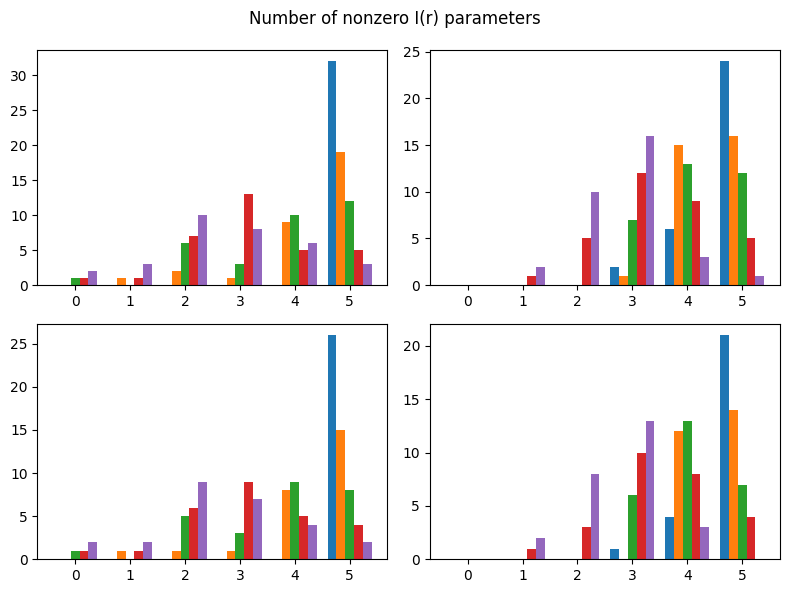

In [86]:
#galaxy, lambda, parameter
#print(all_tables[:, :, 2:7])
#print(zero_median.shape)
#print(zero_median[:, :, 2:7])
nonzero_ir_indiv = 5 - np.sum(zero_indiv[:, :, 2:7], axis = 2)
nonzero_ir_median = 5 - np.sum(zero_median[:, :, 2:7], axis = 2)

nonzero_ir_indiv_nd = 5 - np.sum(zero_indiv[~dip_inds, :, 2:7], axis = 2)
nonzero_ir_median_nd = 5 - np.sum(zero_median[~dip_inds, :, 2:7], axis = 2)
#print(nonzero_ir_median)

fig, axs = plt.subplots(figsize=[8,6], ncols = 2, nrows = 2)

axs[0, 0].hist(nonzero_ir_indiv, bins = np.arange(-0.5, 6.5, 1))
axs[0, 1].hist(nonzero_ir_median, bins = np.arange(-0.5, 6.5, 1))

axs[1, 0].hist(nonzero_ir_indiv_nd, bins = np.arange(-0.5, 6.5, 1))
axs[1, 1].hist(nonzero_ir_median_nd, bins = np.arange(-0.5, 6.5, 1))
fig.suptitle("Number of nonzero I(r) parameters")

fig.tight_layout()
fig.show()